In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import spacy
from tqdm import tqdm

In [2]:
df = pd.read_parquet(path='dataset/youtube-agg-clean-v1.parquet', engine='pyarrow')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1953 entries, 0 to 1955
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   AUTHOR   1953 non-null   string
 1   CONTENT  1953 non-null   string
 2   CLASS    1953 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 61.0 KB


<BarContainer object of 20 artists>

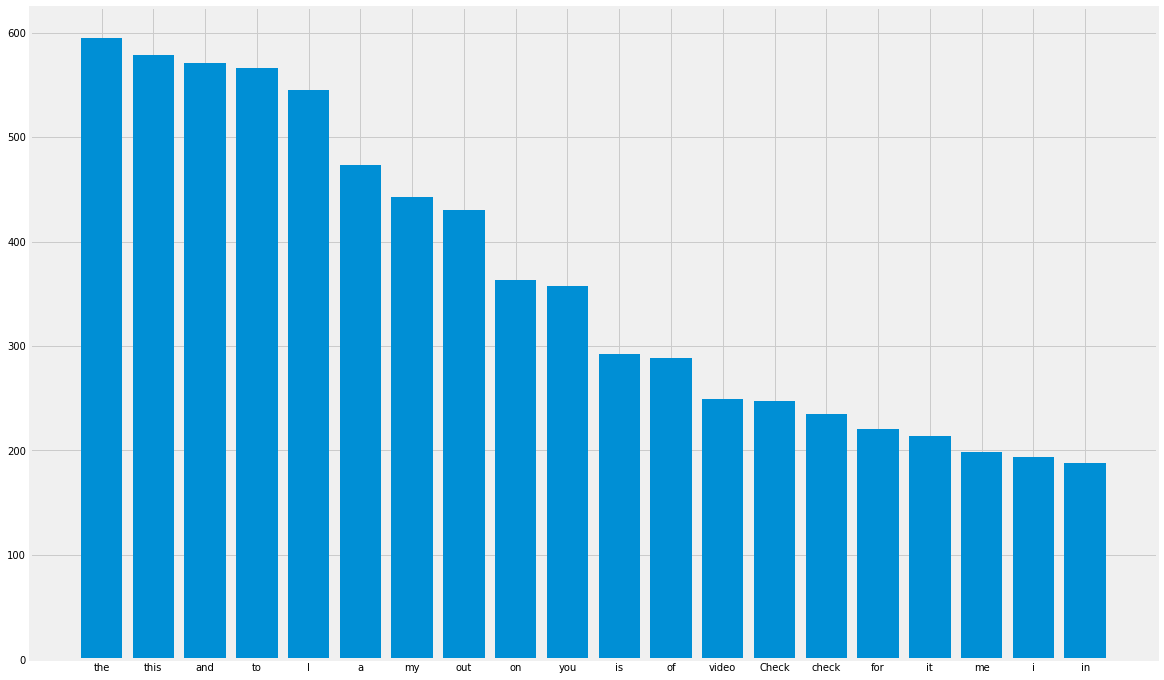

In [3]:
w = dict(Counter([i for j in df['CONTENT'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

<BarContainer object of 20 artists>

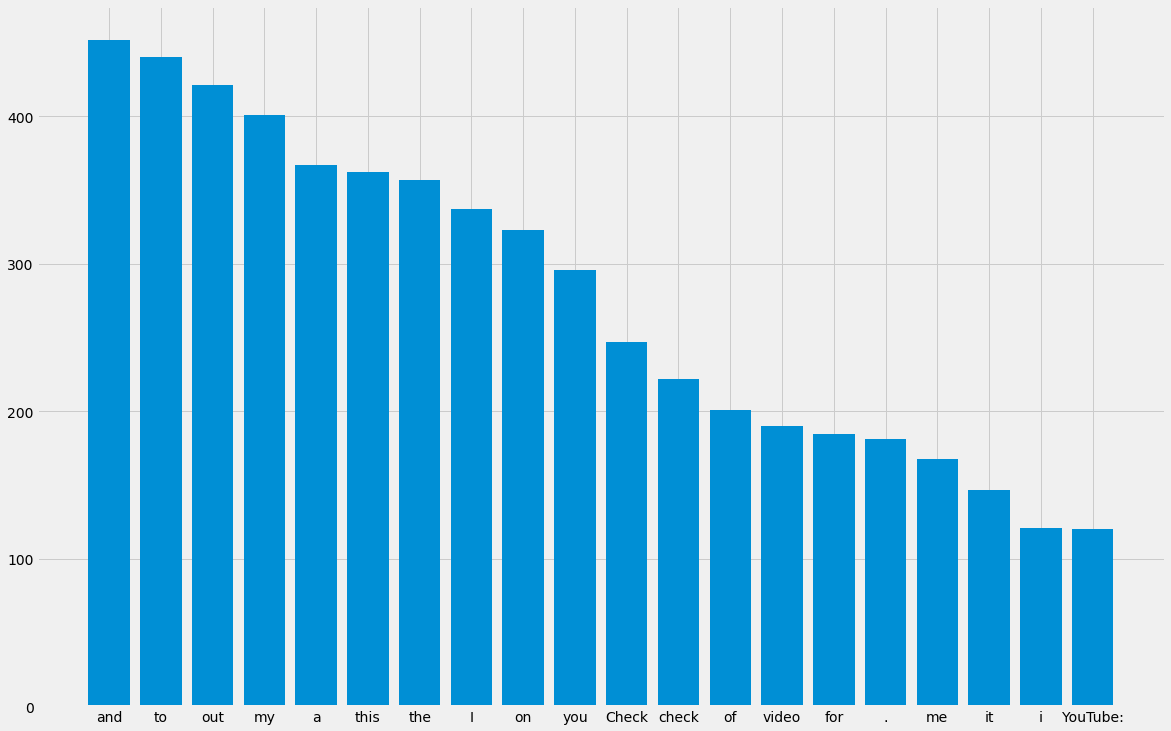

In [4]:
df_tempt = df[df['CLASS'] == 1]
w = dict(Counter([i for j in df_tempt['CONTENT'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

<BarContainer object of 20 artists>

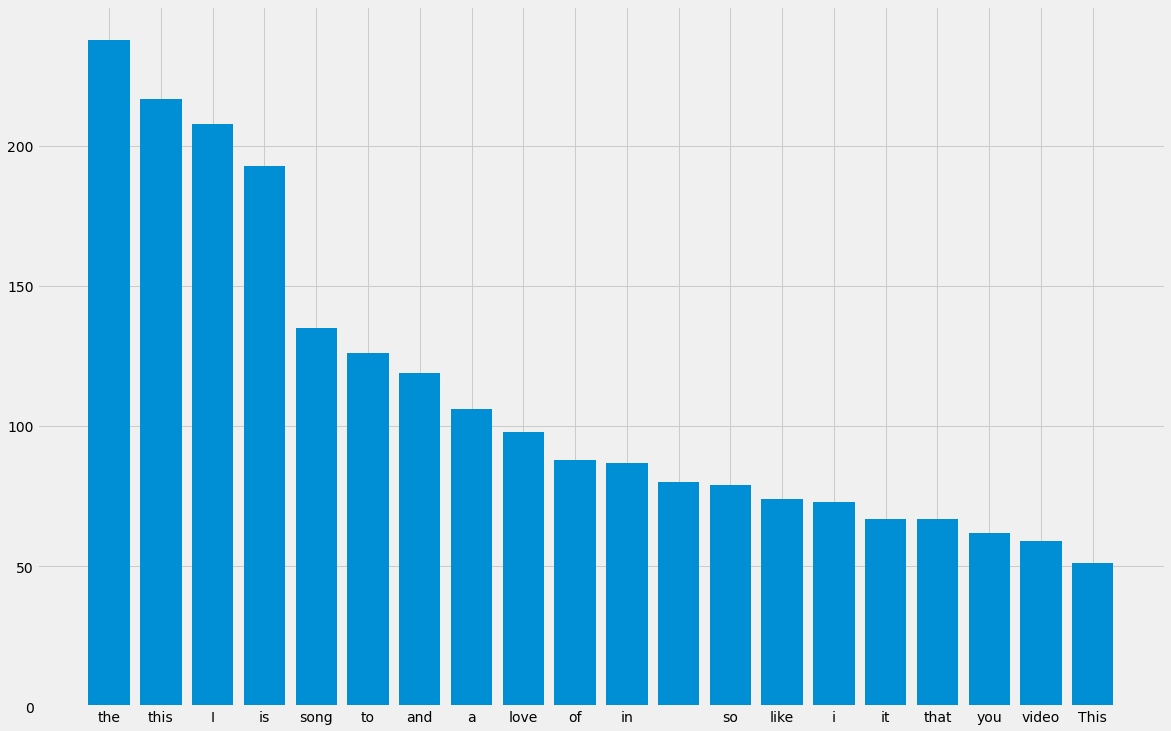

In [5]:
df_tempt = df[df['CLASS'] == 0]
w = dict(Counter([i for j in df_tempt['CONTENT'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

In [6]:
# Remove cases
# ----- Expected output -----
# Before: THIS TEXT WILL BE LOWERCASED. THIS too: ßßß
# After: this text will be lowercased. this too: ssssss
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy
def case_folder(text):
    return text.casefold()


df['CONTENT_EDITED'] = df['CONTENT'].apply(lambda x: case_folder(x))
print(len(df.loc[~(df['CONTENT_EDITED'] == df['CONTENT'])].index))
df.loc[~(df['CONTENT_EDITED'] == df['CONTENT'])].head()

1590


,AUTHOR,CONTENT,CLASS,CONTENT_EDITED
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ..."
1,adam riyati,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,just for test i have to say murdev.com
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿
5,Jason Haddad,"Hey, check out my new website!! This site is a...",1,"hey, check out my new website!! this site is a..."


In [7]:
# removing numbers
# ----- Expected output -----
# Before: Remove these numbers: 1919191 2229292 11.233 22/22/22.
# After: Remove these numbers: .//.
def remove_number(text):
    #return re.sub(r"\b[0-9]+\b\s*", " ", text)
    return ''.join([i for i in text if not i.isdigit()])


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_number(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head()

662


,AUTHOR,CONTENT,CLASS,CONTENT_EDITED,CONTENT_EDITED_TEMP
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...","huh, anyway check out this you[tube] channel: ..."
14,Francisco Nora,please like :D https://premium.easypromosapp.c...,1,please like :d https://premium.easypromosapp.c...,please like :d https://premium.easypromosapp.c...
17,OutrightIgnite,http://www.ebay.com/itm/171183229277?ssPageNam...,1,http://www.ebay.com/itm/171183229277?sspagenam...,http://www.ebay.com/itm/?sspagename=strk:mesel...
18,Tony K Frazier,http://ubuntuone.com/40beUutVu2ZKxK4uTgPZ8K﻿,1,http://ubuntuone.com/40beuutvu2zkxk4utgpz8k﻿,http://ubuntuone.com/beuutvuzkxkutgpzk﻿
20,zhichao wang,i think about 100 millions of the views come f...,0,i think about 100 millions of the views come f...,i think about millions of the views come from...


In [8]:
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

In [9]:
# removing possessive and verb s
def remove_possessive(text):
    return text.replace("'s", '')


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_possessive(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head()

44


,AUTHOR,CONTENT,CLASS,CONTENT_EDITED,CONTENT_EDITED_TEMP
69,OREOGAM3R,It's been back for quite a while now.,0,it's been back for quite a while now.,it been back for quite a while now.
133,HarveyIsTheBoss,You gotta say its funny. well not 2 billion wo...,0,you gotta say its funny. well not billion wor...,you gotta say its funny. well not billion wor...
160,Freddie Barton,CHECK MY CHANNEL FOR MY NEW SONG 'STATIC'!! YO...,1,check my channel for my new song 'static'!! yo...,check my channel for my new song tatic'!! you'...
185,Kitts Hausman,It's so funny it's awesomeness lol aaaaaaa sex...,0,it's so funny it's awesomeness lol aaaaaaa sex...,it so funny it awesomeness lol aaaaaaa sexy la...
215,LaunchPad Mad,"Hello! I'm kind of new to Youtube, And soon i'...",1,"hello! i'm kind of new to youtube, and soon i'...","hello! i'm kind of new to youtube, and soon i'..."


In [10]:
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

In [11]:
# removing special characters
# ----- Expected output -----
# Before: Sample text 123 !!!! Haha.... !!!! ##$$$%%%%
# After: Sample text 123  Haha

def remove_special_char(text):
    return re.sub(r"[^A-Za-z0-9\s]+", "", text)


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_special_char(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head()

1860


,AUTHOR,CONTENT,CLASS,CONTENT_EDITED,CONTENT_EDITED_TEMP
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this youtube channel koby...
1,adam riyati,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say murdevcom
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,watchvvtarggvgtwq check this out


In [12]:
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

In [13]:
# removing words with less than 3 character
def remove_short_word(text):
    return re.sub(r'\b\w{1,2}\b', '', text)


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_short_word(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head()

1496


,AUTHOR,CONTENT,CLASS,CONTENT_EDITED,CONTENT_EDITED_TEMP
1,adam riyati,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out new channel and our first ...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,just for test i have to say murdevcom,just for test have say murdevcom
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy,shaking sexy ass channel enjoy
5,Jason Haddad,"Hey, check out my new website!! This site is a...",1,hey check out my new website this site is abou...,hey check out new website this site about ki...
6,ferleck ferles,Subscribe to my channel ﻿,1,subscribe to my channel,subscribe channel


In [14]:
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

In [15]:
# removing extra whitespaces

def remove_extra_whitespace_tabs(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_extra_whitespace_tabs(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head()

1649


,AUTHOR,CONTENT,CLASS,CONTENT_EDITED,CONTENT_EDITED_TEMP
1,adam riyati,Hey guys check out my new channel and our firs...,1,hey guys check out new channel and our first ...,hey guys check out new channel and our first v...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,just for test have say murdevcom,just for test have say murdevcom
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,shaking sexy ass channel enjoy,shaking sexy ass channel enjoy
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watchvvtarggvgtwq check this out,watchvvtarggvgtwq check this out
5,Jason Haddad,"Hey, check out my new website!! This site is a...",1,hey check out new website this site about ki...,hey check out new website this site about kids...


In [16]:
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

In [17]:
# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [18]:
unique_desc = list(df['CONTENT_EDITED'].unique())
res = []
for doc in tqdm(nlp.pipe(unique_desc, n_process=2)):
    res.append(" ".join(token.lemma_ for token in doc if not token.is_stop))
for inx, item in enumerate(tqdm(unique_desc)):
    df.loc[df[df['CONTENT_EDITED'] == item].index, 'CONTENT_EDITED_TEMP'] = res[inx]

1616it [00:06, 254.84it/s]
100%|██████████| 1616/1616 [00:00<00:00, 3677.13it/s]


In [20]:
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head(15)

1593


,AUTHOR,CONTENT,CLASS,CONTENT_EDITED,CONTENT_EDITED_TEMP
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,huh anyway check out this youtube channel koby...,huh check youtube channel kobyoshi
1,adam riyati,Hey guys check out my new channel and our firs...,1,hey guys check out new channel and our first v...,hey guy check new channel vid monkey monkey wh...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,just for test have say murdevcom,test murdevcom
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,shaking sexy ass channel enjoy,shake sexy ass channel enjoy
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watchvvtarggvgtwq check this out,watchvvtarggvgtwq check
5,Jason Haddad,"Hey, check out my new website!! This site is a...",1,hey check out new website this site about kids...,hey check new website site kid stuff kidsmedia...
7,Bob Kanowski,i turned it on mute as soon is i came on i jus...,0,turned mute soon came just wanted check the views,turn mute soon come want check view
8,Cony,You should check my channel for Funny VIDEOS!!﻿,1,you should check channel for funny videos,check channel funny video
9,BeBe Burkey,and u should.d check my channel and tell me wh...,1,and shouldd check channel and tell what should...,shouldd check channel tell
11,Lone Twistt,Once you have started reading do not stop. If...,1,once you have started reading not stop you not...,start read stop subscribe day entire family di...


In [21]:
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

<BarContainer object of 20 artists>

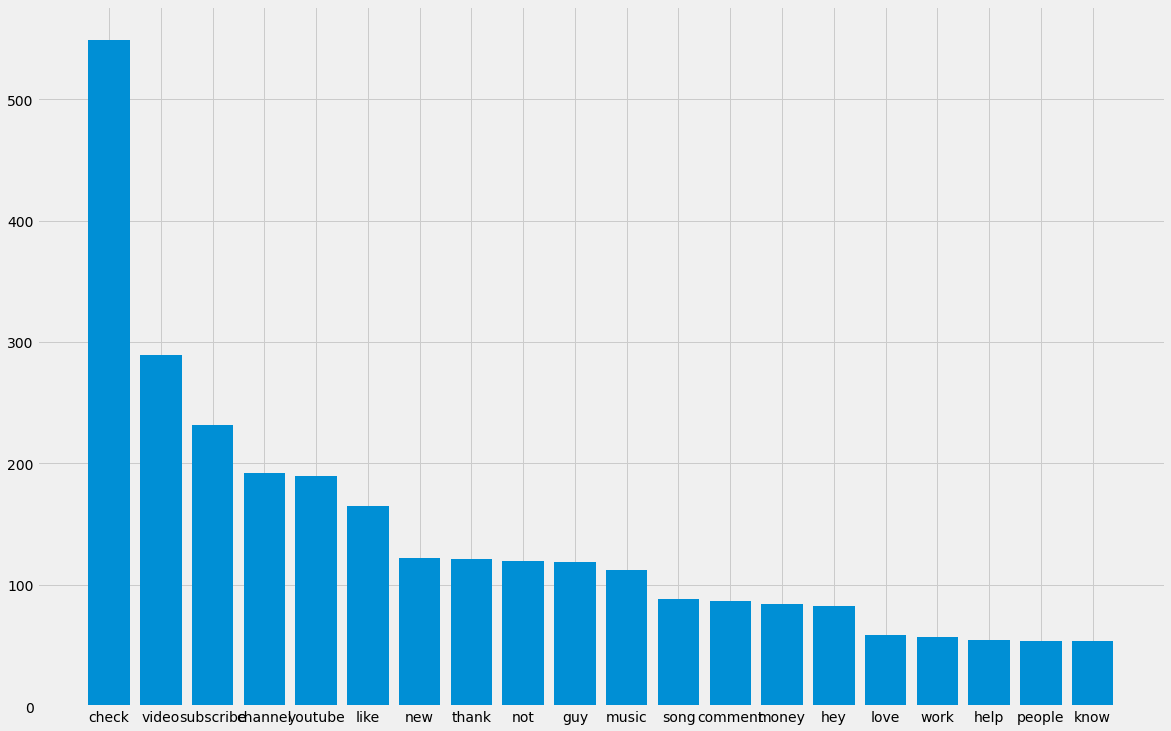

In [22]:
df_tempt = df[df['CLASS'] == 1]
w = dict(Counter([i for j in df_tempt['CONTENT_EDITED'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

<BarContainer object of 20 artists>

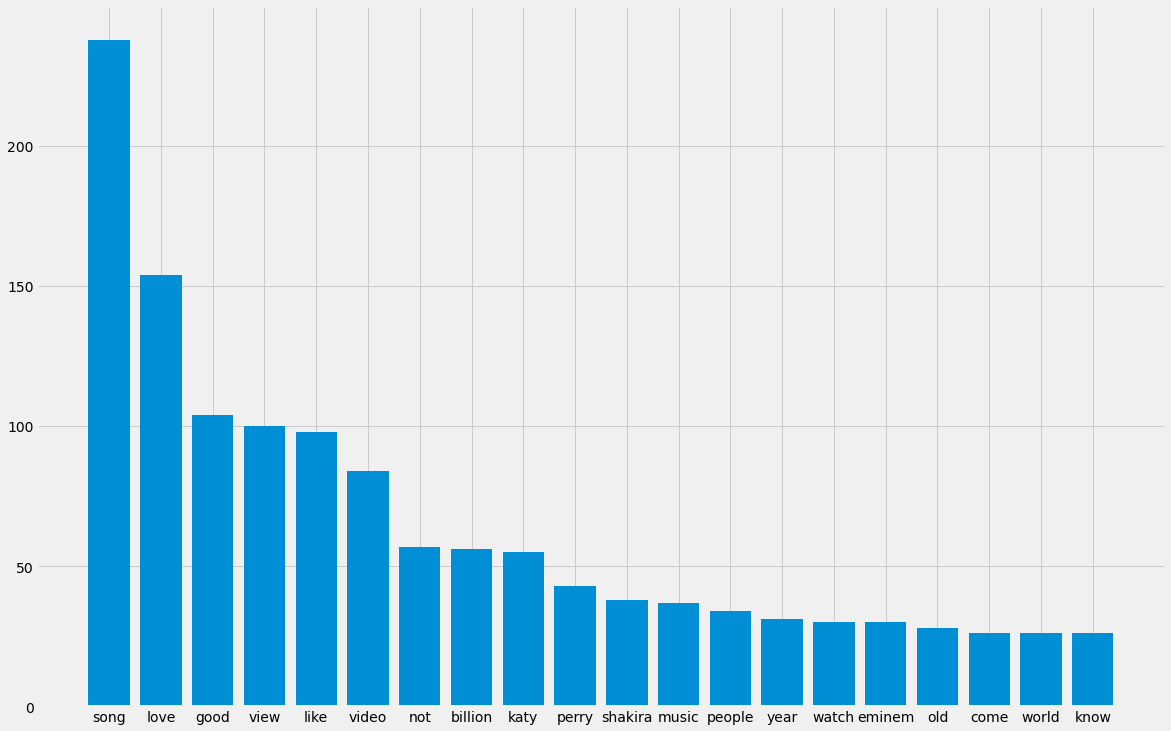

In [23]:
df_tempt = df[df['CLASS'] == 0]
w = dict(Counter([i for j in df_tempt['CONTENT_EDITED'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())